# Libraries

In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

# EDA

**Pseudocode**

- visual inspection (random sampling / extremes)
- metadata (dimensions, aspect ratios, file sizes)
- class distribution
- pixel and colour (check intensity and colour distribution)
- data quality (noise or corrupted images?)
- preprocessing (norm, std, aug)
- other (heatmap/segmentation --> check informative areas)

## Visual Inspection

In [5]:
def get_image_paths(directory):
    '''
    get images paths from saved directory
    '''
    all_files = os.listdir(directory)
    jpeg_files = [file for file in all_files if file.endswith('.jpeg')]
    full_paths = [os.path.join(directory, file) for file in jpeg_files]

    return full_paths


In [25]:
neg_image_paths = get_image_paths('/Users/renatoboemer/Desktop/signet/raw_data/sig-train-neg')
pos_image_paths = get_image_paths('/Users/renatoboemer/Desktop/signet/raw_data/sig-train-pos')
# all_image_paths = neg_image_paths + pos_image_paths

In [12]:
pd.DataFrame(all_image_paths, columns=['path']).head()

,path
0,/Users/renatoboemer/Desktop/signet/raw_data/si...
1,/Users/renatoboemer/Desktop/signet/raw_data/si...
2,/Users/renatoboemer/Desktop/signet/raw_data/si...
3,/Users/renatoboemer/Desktop/signet/raw_data/si...
4,/Users/renatoboemer/Desktop/signet/raw_data/si...


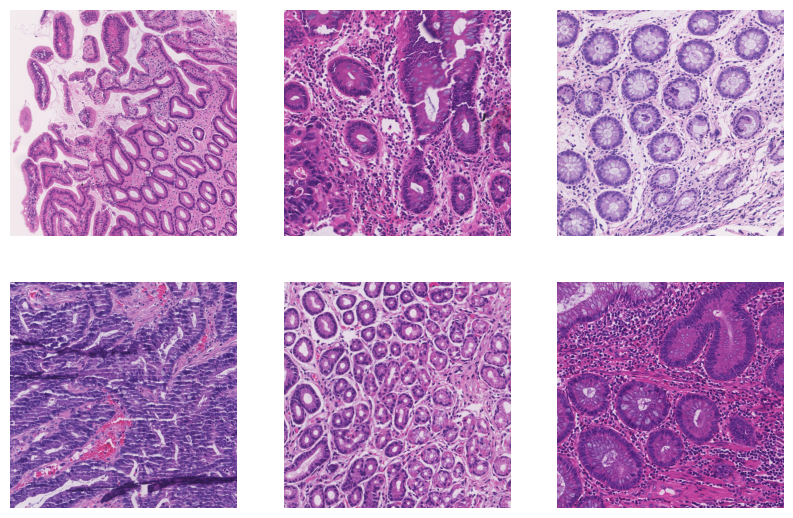

In [23]:
# cancer cells
sampled_paths = random.sample(neg_image_paths, 6)

plt.figure(figsize=(10,10))
for i, path in enumerate(sampled_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show();

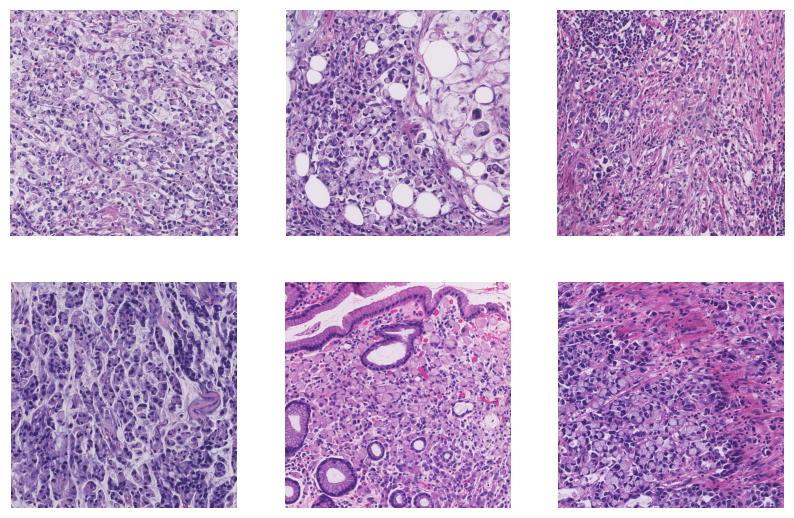

In [24]:
# healthy cells
sampled_paths_pos = random.sample(pos_image_paths, 6)

plt.figure(figsize=(10,10))
for i, path in enumerate(sampled_paths_pos):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show();

**initial observations:**
- cancer cells are larger, potentially because of mucin accumulation (cancer stage?)
- tissues with cancer have darker tone, potentially due to inflamation (different organs?)
- cancer cells have a dark and thick membrane.
- cancer cells can be grouped or spread out.
- some exceptions in cancer images have been observed.

In [29]:
# check for extreme cases
def calc_brightness(img):
    if len(img.shape) == 3:  # 3 colour channels
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    return np.average(gray)

In [34]:
pos_img_sizes = []
pos_img_brightness = []

for path in pos_image_paths:
    pos_img = cv2.imread(path)
    
    pos_img_size = pos_img.shape[0] * pos_img.shape[1]  # image size in pixels
    pos_img_sizes.append(pos_img_size)
    
    pos_brightness = calc_brightness(pos_img)
    pos_img_brightness.append(pos_brightness)


pos_image_sizes = np.array(pos_img_sizes)
pos_image_brightness = np.array(pos_img_brightness)

In [35]:
neg_img_sizes = []
neg_img_brightness = []

for path in neg_image_paths:
    neg_img = cv2.imread(path)
    
    neg_img_size = neg_img.shape[0] * neg_img.shape[1]  # image size in pixels
    neg_img_sizes.append(neg_img_size)
    
    neg_brightness = calc_brightness(neg_img)
    neg_img_brightness.append(neg_brightness)


neg_image_sizes = np.array(neg_img_sizes)
neg_image_brightness = np.array(neg_img_brightness)

In [54]:
data_temp = pd.DataFrame({
    'size': np.concatenate([pos_image_sizes, neg_image_sizes]),
    'brightness': np.concatenate([pos_image_brightness, neg_image_brightness]),
    'label': ['pos'] * len(pos_image_sizes) + ['neg'] * len(neg_image_sizes)})

In [55]:
data_temp.head()

,size,brightness,label
0,4184672,179.346061,pos
1,4131056,141.484418,pos
2,4255680,183.736166,pos
3,4064256,174.998885,pos
4,4163584,145.885209,pos


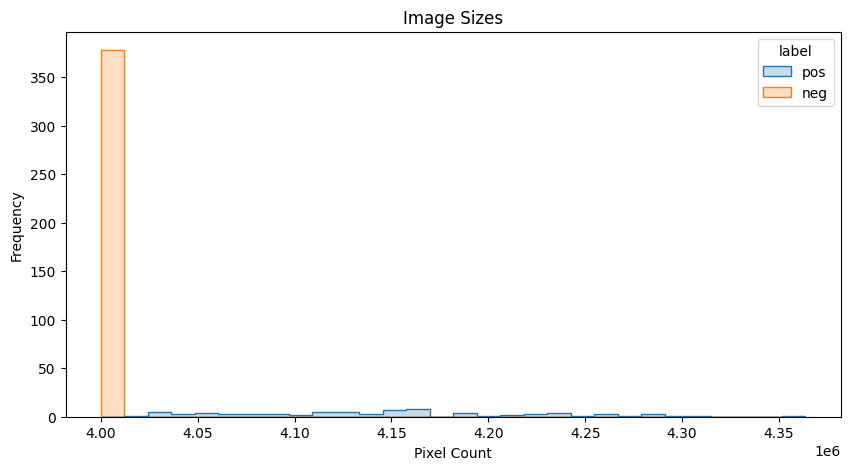

In [56]:
# plot sizes
plt.figure(figsize=(10, 5))
sns.histplot(data=data_temp,
             x='size',
             hue='label',
             element='step',
             bins=30,
             common_norm=False)
plt.title('Image Sizes')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency');

**some observations about pixels:**
- significant difference between classes. So, neg images might have fewer details.
- standardisation (resizing is necessary for constant input)
- check if researchers improved model with emsemble method that detects details (due to small img size). More convolutional layers?


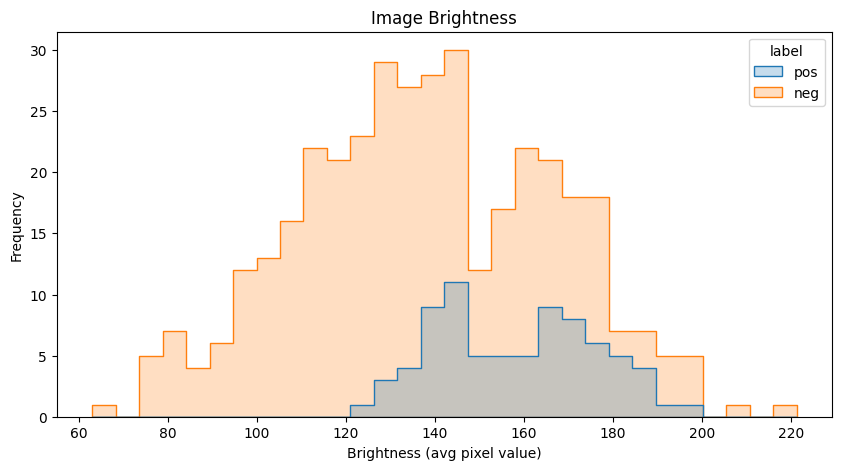

In [57]:
# plot brightness
plt.figure(figsize=(10, 5))
sns.histplot(data=data_temp,
             x='brightness',
             hue='label',
             element='step',
             bins=30,
             common_norm=False)
plt.title('Image Brightness')
plt.xlabel('Brightness (avg pixel value)')
plt.ylabel('Frequency');

**some observations about brightenss:**
- significant difference between classes again. Neg classes have wider range which overlaps with the Pos class. So, brightness might not be very helpful in distinguishing between classes.
- different brightness could be associated with organ type (as mentioned earlier) given the dataset includes tissue from multiple organs.
- perhaps texture might be a better predictive feature.

In [ ]:
class DataLoader:
    def __init__(self, pos_dir, neg_dir, image_size, batch_size):
        self.pos_dir = pos_dir
        self.neg_dir = neg_dir
        self.image_size = image_size
        self.batch_size = batch_size

    def get_image_paths(self):
        pos_images = [os.path.join(self.pos_dir, f) for f in os.listdir(self.pos_dir) if f.endswith('.jpeg')]
        neg_images = [os.path.join(self.neg_dir, f) for f in os.listdir(self.neg_dir) if f.endswith('.jpeg')]
        labels = [1] * len(pos_images) + [0] * len(neg_images)
        return pos_images + neg_images, labels

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)
        return image

    def preprocess_images(self, image_paths, labels):
        images = [self.load_image(path) for path in image_paths]
        images = np.array(images) / 255.0 
        labels = np.array(labels)
        return images, labels

    def data_generator(self):
        image_paths, labels = self.get_image_paths()
        while True:  # Loop indefinitely
            for i in range(0, len(image_paths), self.batch_size):
                batch_paths = image_paths[i:i + self.batch_size]
                batch_labels = labels[i:i + self.batch_size]
                images, labels = self.preprocess_images(batch_paths, batch_labels)
                yield images, to_categorical(labels, num_classes=2)
